In this session we will load an audio research dataset, and analyse it using spectrogram-based audio features, as well as pre-trained deep learning features.

If you want to work on your PC, install the python package dependencies. Here's how on Debian or Ubuntu, using the terminal *command line*:

First we create a "virtual environment" to install packages without altering your core Python install. This is optional but highly recommended:

```
python3 -m venv venv
source activate venv/bin/activate
```

If you do the above, your Jupyter list of python kernels will have a new entry `venv_vggish`. When you launch Jupyter, you need to select that as the kernel used to run your code.
Go to the menu option **Kernel>Change kernel>venv_vggish**.

These are the **required** terminal commands to install needed packages:

```
# now install the modules
source activate venv/bin/activate
pip install numpy scipy
pip install librosa matplotlib seaborn jupyter
pip install torch
```

If you used a virtualenv, then after installing all the packages you should register your virtualenv to be available within the notebook:

```
python -m ipykernel install --user --name=venv_vggish
```

Download **torchvggish** package from here https://github.com/harritaylor/torchvggish and put it into your workspace. You don't have to do it if you work on jhub since I already included it in the `Lab3` folder,

In [45]:
import torchvggish
import torch
from torchvggish import vggish_input, vggish, vggish_params, mel_features
from torchvggish import vggish
from hubconf import *

In [2]:
# Import the packages we'll use

import numpy as np
import os, glob, csv

# librosa is a widely-used audio processing library
import librosa

# torchvggish gives us access to pretrained vggish within PyTorch
from torchvggish import vggish, vggish_input

# sklearn is a widely-used machine learning library
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline



In case you work on your PC, if you haven't already done so, download the dataset. It is called "warblrb10k" and was created as part of the [Bird Audio Detection challenge](https://doi.org/10.1111/2041-210X.13103).

Don't click these links unless you've the bandwidth to download!

* The [WAV audio data](https://archive.org/download/warblrb10k_public/warblrb10k_public_wav.zip) are 4.6 GB. Beware - this could take hours to download on a slow connection.
* The [CSV annotation data](https://figshare.com/articles/Bird_Audio_Detection_Challenge_2016_public_data/3851466) are 200 kB.

In [11]:
# USER CONFIGURATION
# Please alter the paths here to where the data are stored on your local filesystem
binarylabelcsv  = os.path.expanduser("./warblrb10k_test/warblrb10k_public_metadata.csv")
audiofilefolder = os.path.expanduser("./warblrb10k_test/wav")

maxfilestoload  = 100      # limit, because loading the whole dataset is v slow


In [36]:
# here we load the metadata labels
wavs = []
for wav in os.scandir(audiofilefolder):
    wavs.append(wav.name[0:-4])
binarylabels = {}
with open(binarylabelcsv, 'r') as infp:
        rdr = csv.DictReader(infp)
        for row in rdr:
            if row['itemid'] in wavs:
                binarylabels[row['itemid']] = int(row['hasbird'])
            if len(binarylabels)==maxfilestoload:
                break  # note, here we are restricting the maximum number of rows.

fkeys = sorted(binarylabels.keys())
print(fkeys)


['0a0b783d-f9a3-4652-a01d', '0a1155db-89a3-4c69-8aa9', '0a160dd5-9c7e-4e2f-8bd7', '0a26bc2e-ac78-41b4-bcf3', '0a29f1f2-aac0-40bf-a93e', '0a2c4685-1a1b-4e37-96fb', '0a2c929d-0e63-414b-bf90', '0a3c5d54-bf32-4a1d-aab4', '0a42af88-f61a-4504-9ba2', '0a4e8000-574c-46b8-a847', '0a4ef72d-611f-4adc-9cf1', '0a6358e9-fbb7-4bff-8b95', '0a69a7ce-5aeb-4627-9266', '0a7e2a2a-a679-4c5c-818f', '0a83aa66-db06-49e6-b477', '0a8957e6-2647-4cec-ae72', '0a8ad8e4-c84a-4db0-9581', '0a981a08-74dc-4f74-94ed', '0a9a74b9-18ec-4c35-9c59', '0a9da934-d6ac-48f1-9739']


Next we will load the WAV audio data and convert each file to mel-spectrogram features. We can use `librosa` to do this (in general, that's a good idea). However, later we're going to be using the "VGGish" neural net to analyse data, and in the VGG paper the researchers describe their mel-spectrogram implementation, which is slightly different. So, we will instead use a feature extraction function from the `torchvggish` package.

In [24]:
# Loading the audio data and extract mel spectrograms using the function of the torchvggish package
# WARNING: this will be SLOW if maxfilestoload is a large number. (50 files takes about 20 seconds)
melspecs = {itemid:vggish_input.wavfile_to_examples("%s/%s.wav" % (audiofilefolder, itemid))
    for itemid, hasbird in binarylabels.items()}
# There may be some unusual entries with very short audio.
# If so we will delete them from our data in memory, since we cannot analyse them usefully.
for itemid in list(binarylabels.keys()):
        if melspecs[itemid].shape[0] == 0:
                print("Deleting zero-length entry %s" % (itemid))
                del melspecs[itemid]
                del binarylabels[itemid]

In [35]:
# Let's look at the data structure we have for one example
example = melspecs[fkeys[0]]

# Observe that "example" is NOT a numpy array. It's a Torch-specific data type
print("example.shape:")
print(example.shape)

# Here's how you convert it to a numpy array:
example_np = example.detach().numpy()
print("example_np.shape:")
print(example_np.shape)


example.shape:
torch.Size([10, 1, 96, 64])
example_np.shape:
(10, 1, 96, 64)


Our "example" is a four-dimensional tensor.

(10, 1, 96, 64)

QUESTION 1: What do these four dimensions represent? Hint, your audio files are 10 seconds long while the VGGish model receives an input of around 1 second audio.

* 10: ?
* 1: ?
* 96: ?
* 64: ?

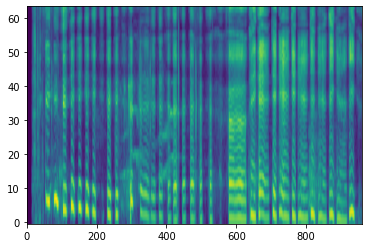

In [15]:
# Let's look at the spectrogram of one example
# We use numpy "concatenate" to join the 1-second chunks back together.
plt.imshow(np.concatenate(np.concatenate(example_np)).T, aspect='auto', origin='lower')


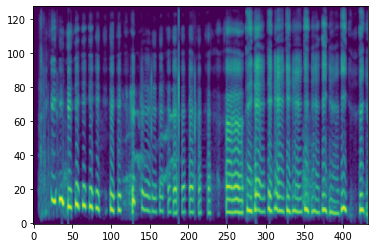

In [16]:
# For comparison, we can analyse the same audio file with librosa
y, sr = librosa.load("%s/%s.wav" % (audiofilefolder, fkeys[0]))
example_librosa = librosa.feature.melspectrogram(y=y, sr=sr)
example_librosa = librosa.power_to_db(example_librosa, ref=np.max)
plt.imshow(example_librosa, aspect='auto', origin='lower')


EXERCISE: look at the librosa documentation to find how to modify the options in the mel spectrogram calculation, and make this spectrogram match the VGGish one as close as possible.

Now let's start to **perform some analysis** on the feature data. We'll start by analysing the spectrograms and how they relate to the class labels.

This is a binary dataset: each audio file is labelled with **0** if there are no birds audible, and **1** if there is at least one bird audible.

Does the spectrogram data contain sufficient information to decide automatically if a particular file should be 0 or 1?

In [64]:
# PCA (principal components analysis)

# Note that we will collapse the "frames" axis so that each one-second chunk is represented by a single vector,
# i.e. an average spectral profile for that one second.
# We do this by taking the mean.

# We're going to loop over the spectrograms, and the binary labels, in parallel,
# so that we're sure they're in the same ordering.

binarylabels_serial = []
Xforpca = []
for akey in fkeys:
    if akey in melspecs:
        aspec = melspecs[akey].detach().numpy()
        aspec = aspec.mean(axis=(1,2))    # Here is where we apply that time-averaging for each clip.
        if aspec.shape != (10,64):
                print("  warning: skipping item %s because melspec is unexpected shape" % akey)
                continue
                
        binarylabels_serial.extend([binarylabels[akey]] * aspec.shape[0])
        Xforpca.append(aspec)

print(np.array(Xforpca).shape)
print(np.array(binarylabels_serial).shape)
Xforpca = np.array(Xforpca).reshape((-1, 64))
print(Xforpca.shape)
pca = PCA(n_components=2, whiten=True)
pcadata = pca.fit_transform(Xforpca) # shape (nsamples, nfeatures)

assert len(binarylabels_serial) == Xforpca.shape[0], "len(binarylabels_serial) != Xforpca.shape[0]. %i != %i" % (len(binarylabels_serial), Xforpca.shape[0])


(20, 10, 64)
(200,)
(200, 64)


In [38]:
# This convenience function will help us plot
def scatterplot(xs, ys, title, datalabels):
    plt.figure(frameon=False, figsize=(5, 5))
    plt.scatter(xs, ys, alpha=0.2,
                c=[{0: 'b', 1: 'g'}[albl] for albl in datalabels],
               )
    plt.title(title)
    plt.tight_layout()


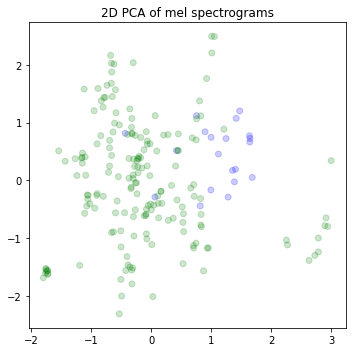

In [39]:
scatterplot(pcadata[:,0], pcadata[:,1], "2D PCA of mel spectrograms", binarylabels_serial)

QUESTION 2: Does this plot give an impression that the two classes can be separated?

In [46]:
# Now let's put the data through the VGGish network.

# This may take a little while (10 seconds), or longer if the library has not yet downloaded VGGish.
embedding_model = vggish(preprocess=False)
embeddings = {key:embedding_model.forward(item).detach().numpy() for key,item in sorted(melspecs.items())}


Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth" to C:\Users\xiede/.cache\torch\hub\checkpoints\vggish-10086976.pth


  0%|          | 0.00/275M [00:00<?, ?B/s]

Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish_pca_params-970ea276.pth" to C:\Users\xiede/.cache\torch\hub\checkpoints\vggish_pca_params-970ea276.pth


  0%|          | 0.00/177k [00:00<?, ?B/s]

In [53]:
# VGG creates a 128-dimensional vector ("embedding") for each spectrogram chunk.
print(embeddings[fkeys[0]].shape)

(10, 128)


In [48]:
# Again, let's apply PCA so we can at least partly visualise the 128D outcome.

binarylabels_serial = []
Xforpca_vgg = []
for akey in fkeys:
    if akey in embeddings:
        if embeddings[akey].shape != (10,128):
            print("  warning: skipping item %s because embedding is unexpected shape" % akey)
            continue
        binarylabels_serial.extend([binarylabels[akey]] * embeddings[akey].shape[0])
        Xforpca_vgg.append(embeddings[akey])


Xforpca_vgg = np.array(Xforpca_vgg).reshape((-1, 128))
pca = PCA(n_components=2, whiten=True)
pcadata_vgg = pca.fit_transform(Xforpca_vgg) # shape (nsamples, nfeatures)

assert len(binarylabels_serial) == Xforpca_vgg.shape[0], "len(binarylabels_serial) != Xforpca.shape[0]. %i != %i" % (len(binarylabels_serial), Xforpca.shape[0])


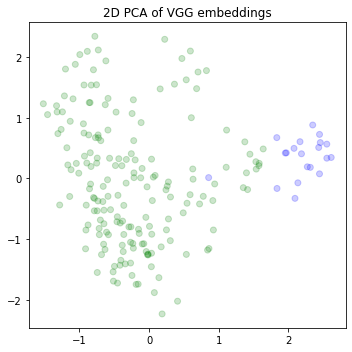

In [49]:
scatterplot(pcadata_vgg[:,0], pcadata_vgg[:,1], "2D PCA of VGG embeddings", binarylabels_serial)

QUESTION 3: Does this plot give an impression that the two classes can be separated?

QUESION 4: Why PCA is not necessarily a good idea for this analysis?

Let's investigate this by performing *logistic regression* on the data, instead of PCA. Logistic regression is a supervised learning algorithm, so it will use the class labels to learn its projection.

Logistic regression is a lot like a single layer of a typical neural network. (Or, an extremely "shallow" neural network with no hidden layers between input and output.) If we perform logistic regression on the output of the VGG network, it's a bit like we're creating a new deep model with many layers, except most of the layers are pretrained, and only the last layer has been trained for our bird detection task!

Text(14.875, 0.5, 'Audio clip index')

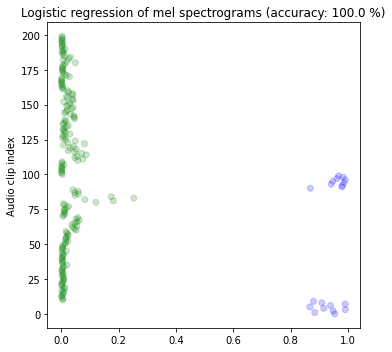

In [50]:
# Logistic regression applied directly to the mel spectrograms
lgr = LogisticRegression(solver='liblinear')
lgr.fit(Xforpca, binarylabels_serial)
lgrdata = lgr.predict_proba(Xforpca) # shape (nsamples, nfeatures)
lgrscore = lgr.score(Xforpca, binarylabels_serial) * 100

scatterplot(lgrdata[:,0], range(len(lgrdata)), "Logistic regression of mel spectrograms (accuracy: %.1f %%)" % lgrscore, binarylabels_serial)
plt.ylabel("Audio clip index")

Text(14.875, 0.5, 'Audio clip index')

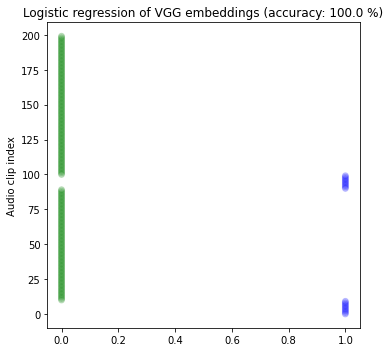

In [51]:
# Logistic regression applied to the VGG embeddings
lgr = LogisticRegression(solver='liblinear')
lgr.fit(Xforpca_vgg, binarylabels_serial)
lgrdata_vgg = lgr.predict_proba(Xforpca_vgg) # shape (nsamples, nfeatures)
lgrscore_vgg = lgr.score(Xforpca_vgg, binarylabels_serial) * 100

scatterplot(lgrdata_vgg[:,0], range(len(lgrdata)), "Logistic regression of VGG embeddings (accuracy: %.1f %%)" % lgrscore_vgg, binarylabels_serial)
plt.ylabel("Audio clip index")

We used scikit-learn's "score" function to calculate the accuracy of the logistic regression when used as a classifier. (Printed into the titles on the plots.) 

QUESTION 5: Do these accuracies reflect the differences you see (or don't see) in the scatter plots? Why / why not?

QUESTION 6: What could be done further to improve the accuracy of classification, using a VGG-based model?